#Triple states

First, set up some signal processing functions that give us similar sorts of state/reward information as they have created in their paper.

Next, set up a similar Reinforcement Learning algorithm as Nagaraj. The main difference is the use of a SoftMax action selection policy which is a probabilistic distribution based on the expected reward of each action.

Finally, test the results in a similar format that they have set up.

Ideas for improving their paper: extending the binary state-space to a multi-dimensional continuous vector; extend the action space to amplitude and frequency-varying signals and introduce an offline learning method.

In [1]:
%pylab nbagg
from tvb.simulator.lab import *


Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


In [2]:
from sklearn.ensemble import ExtraTreesRegressor
import operator
from scipy.signal import butter, lfilter

In [3]:
import scipy

I have created a library with a few very useful functions for The Virtual Brain. This can be found in sim.py.

In [4]:
import sim

#Extracting State and Reward

The Nagaraj paper depends on extracting state information (ictal vs inter-ictal) through a binary partitioning of the state space of the Epileptor model. This seems rather unnecessary considering the same information can be extracted from the DC-offset in the LFP signal during ictal periods. The state information will be kept as a simplistic model for now, until I know more about how to do some signal processing on it. 

Reward, on the other hand, is a little bit more sophisticated.

In [5]:
def get_avg(raw_data, region):
    data_min = np.min(raw_data[:],0)[0]
    data_max = np.max(raw_data[:],0)[0]
    data_rng = data_max - data_min
    data_avg = np.mean(raw_data[:], 0)[0]
    return data_avg[region]

Refer to http://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass and http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

In [6]:
def bp_filter_lfp(raw_data, region, f_lo, f_hi, f_sampl, order = 5):
    region_data = []
    for i in range(len(raw_data)):
        region_data.append(raw_data[i][0][region][0])
        
    b,a = make_butter(f_lo, f_hi, f_sampl, order, 'band')
    data_f = lfilter(b,a,region_data)
        
    return data_f
    

In [7]:
def lo_filter_lfp(raw_data, region, f_lo, f_sampl, order = 5):
    region_data = []
    for i in range(len(raw_data)):
        region_data.append(raw_data[i][0][region][0])
    b,a = make_butter(f_lo, 0, f_sampl, order, 'lowpass')
    data_f = lfilter(b,a,region_data)
    return data_f

In [8]:
def hi_filter_lfp(raw_data, region, f_hi, f_sampl, order = 5):
    region_data = []
    for i in range(len(raw_data)):
        region_data.append(raw_data[i][0][region][0])
    b,a = make_butter(0, f_hi, f_sampl, order, 'highpass')
    data_f = lfilter(b,a,region_data)
    return data_f

In [9]:
def make_butter(f_lo, f_hi, f_sampl, order, f_type):
    f_nyquist = 0.5*f_sampl
    lo = f_lo/f_nyquist
    hi = f_hi/f_nyquist
    if f_type == 'band' or f_type == 'bandpass': 
        b,a = butter(order, [lo, hi], btype = f_type)
    elif f_type == 'lowpass' or f_type == 'low':
        b,a = butter(order, lo, btype = f_type)
    else:
        b,a = butter(order, hi, btype = f_type)
    return b,a

Use exponential smoothing, because I don't understand their smoothing technique and can't get it to work: https://en.wikipedia.org/wiki/Exponential_smoothing#Basic_exponential_smoothing

In [28]:
def get_reward(lfp_t, lfpbar_oldt, stim_cost, time_const = 3):
    
    
    #lfp_t_filtered = bp_filter_lfp(lfp_t, 9, 100, 200, 1000, 10)
    lfp_t_filtered = hi_filter_lfp(lfp_t, 9, 175, 1000, 10)
    
    #mid = lfp_t_filtered[(len(lfp_t_filtered)/2)] #do i take the median?
    #mid = sum(lfp_t_filtered)/len(lfp_t_filtered) #or the mean?
    
    alpha_smooth = 1 - np.exp(-1/float(time_const))
    
    
    lfp_sq = []
    for pt in lfp_t_filtered:
        lfp_sq.append(pt**2)
    
    max_raw = max(lfp_t_filtered)
    min_raw = min(lfp_t_filtered)
    rng_raw = max_raw - min_raw

    lfpbar_t = alpha_smooth * rng_raw + (1-alpha_smooth) * lfpbar_oldt
    
    reward = - np.log(10*lfpbar_t) - stim_cost
    return (reward, lfpbar_t)
    
    

In [189]:
test_rewards = []
test_deltas = []

lfpbars = []
for i in range(len(ttest)/dt):
    if i == 0:
        oldlfpbar = 0
        oldrew = 0
    else:
        oldlfpbar = lfpbars[i-1]
        oldrew = rewards[i-1]
        
    stimcost = take_action(actions[i])
    rew, lfpbar = get_reward(ttest[dt*i:dt*(i+1)], oldlfpbar, stimcost)
    test_rewards.append(rew)
    test_deltas.append()

IndexError: invalid index to scalar variable.

#Defining the Action Space

For now, actions:

    0: no stimulus
    1: 10  Hz; amp = 1
    2: 10  Hz; amp = 5
    3: 50  Hz; amp = 1
    4: 50  Hz; amp = 5
    5: 100 Hz; amp = 1
    6: 100 Hz; amp = 5

Cost of every action is proportional to the power delivered. So 

    power_per_dt = dt * duty cycle * amp^2

In [11]:
valid_actions = [0,7,8]

In [12]:
def take_action(action, stim = 0):
    if action == 0:
        amp = 0
        T = 100
        tau = 0
        
    elif action == 1:
        amp = 1
        T = 100
        tau = 50

    elif action == 2:
        amp = 5
        T = 100
        tau = 50

    elif action == 3:
        amp = 1
        T = 20
        tau = 10
        
    elif action == 4:
        amp = 5
        T = 20
        tau = 10

    elif action == 5:
        amp = 1
        T = 10
        tau = 5
        
    elif action == 6:
        amp = 5
        T = 10
        tau = 5
        
    elif action == 7:
        amp = 10
        T = 100
        tau = 50
    elif action == 8:
        amp = 10
        T = 50
        tau = 25
        
    else:
        amp = 0
        T = 100
        tau = 0
    if stim != 0:
        stim.temporal.parameters["amp"] = amp
        stim.temporal.parameters["T"] = T
        stim.temporal.parameters["tau"] = tau
    power_per_ms = (float(tau)/T) * (amp ** 2)
    return power_per_ms

#Q-Learning Functions

In [13]:

        
def get_q(q_table, state, action):
    return q_table.get((state,action), 0)
    
def update_q(q_table, state,action, newval):
    q_table[(state, action)] = newval

def learn_from_exp(q_table, state1, state2, action, reward, gamma = 0.9, alpha = 0.2):
    
    oldval = get_q(q_table, state1, action)
    
    maxq_state2 = max([get_q(q_table, state2, a) for a in actions]) # = V(s') 
    
    # Q(s,a) <- Q(s,a) + alpha * [reward + gamma * V(s') - Q(s,a)]
    
    newval = oldval + alpha * (reward + gamma * maxq_state2 - oldval)
    #should it be different for the first try??
    
    update_q(q_table, state1, action, newval)
    
def choose_action(q_table, state, valid_actions, epsilon = 0):

    if random.random() < epsilon:
        action = random.choice(valid_actions)
      
   
    else:
        q = [get_q(q_table, state, a) for a in valid_actions]
        max_q = max(q)
        count = q.count(max_q)
        if count == 1:
            i = q.index(max_q)
        else:
            best_acts = [i for i in range(len(valid_actions)) if q[i] == max_q]
            i = random.choice(best_acts)
        action = valid_actions[i]
    return action

#Make some data

Standard setup, only one region for now.

In [14]:
epileptic = [9]
almost_epileptic = []
stimulus_target = [9]
stimulus_amplitude = 0
stimulus_weight = 2 #0-2 for each region
onset = 0
period = 500
pulse_width = 0
sim_time = 10000
dt = 100

(s, stimulus) = sim.set_sim(epileptic, almost_epileptic, stimulus_target, stimulus_amplitude, 
              stimulus_weight, onset, period, pulse_width, sim_time)

WARNING  File 'hemispheres' not found in ZIP.


Get rid of noisy initial conditions

In [15]:
s.run(simulation_length=3000)
print("")

In [31]:
states = []
actions = []
rewards = []
delta_rewards = []
lfpbars = []
q_table = {}
sim_time = 10000

stimulating = 0
post_stimulus = 0

for i in range(sim_time/dt):
    
    #Print to have an idea of how far the execution is
    if i%10 == 0:
        print "time: " + str(i*dt)
        
    #first action is blank, lfpbar_previous is used to smooth rewards
    #action[i] is the action currently happening at t = i
    if i == 0:
        actions.append(0) 
        lfpbar_previous = 0
        previous_state = 0
    else:
        lfpbar_previous = lfpbars[i-1]
        previous_state = states[i-1][0]
    
    take_action(actions[i], stimulus)

    #Run stimulation for dt
    (t, a), (x1, x2), (y1, y2) = s.run(simulation_length = dt)
    
    #keep a global sequence of raw data
    if i == 0:
        ttest = copy(t)
        atest = copy(a)
    else:
        ttest = np.append(ttest, t, axis=0)
        atest = np.append(atest, a, axis=0)
    
    lfp_avg = get_avg(a,9)
    #state = (lfp_avg, )
    if lfp_avg < 0:
        state = (1,)#previous_state)
    else:
        state = (0,)#previous_state)
    
    states.append(state)
    
    #Choose next action based on current state
    
    #CHANGED SO THERE IS A REFRACTORY PERIOD AFTER ACTION

    if i%3 == 0:
        next_action = choose_action(q_table, state, valid_actions, epsilon = 0.1)

    else:
        next_action = 0 

        
    actions.append(next_action)
    
    #Get our reward with the fancy new reward function
    reward, lfpbar = get_reward(a, lfpbar_previous, 0)
    rewards.append(reward)
    lfpbars.append(lfpbar)
    
    
    
    #update q_table using experience
    #Change rewards! now it's difference between current reward and previous one

    if (i+1)%3 == 0:
        #real_reward = rewards[i]-rewards[i-2] - 0.025*take_action(actions[i-1])
        real_reward = rewards[i]-rewards[i-2] - 0.025*take_action(actions[i-1])
        
        learn_from_exp(q_table, states[i-2], states[i], actions[i-1], real_reward)
        delta_rewards.append(real_reward)

    else:
        if i == 0:
            delta_rewards.append(0)
        else:
            delta_rewards.append(delta_rewards[i-1])
#    real_reward = float('nan')
#    if i > 1 and actions[i-1] != 0 :
#        real_reward = rewards[i] - rewards[i-2] - 0.025*action_pen
#        learn_from_exp(q_table,states[i-2], states[i], actions[i-1], real_reward)
#        
#    elif i > 0 and actions[i-1] == 0 and actions[i] == 0:
#        real_reward = rewards[i] - rewards[i-1] - 0.025*action_pen
#        learn_from_exp(q_table, states[i-1], states[i], actions[i], real_reward)
#    delta_rewards.append(real_reward)

time: 0
time: 1000
time: 2000
time: 3000
time: 4000
time: 5000
time: 6000
time: 7000
time: 8000
time: 9000


In [19]:
len(delta_rewards)

101

<IPython.core.display.Javascript object>


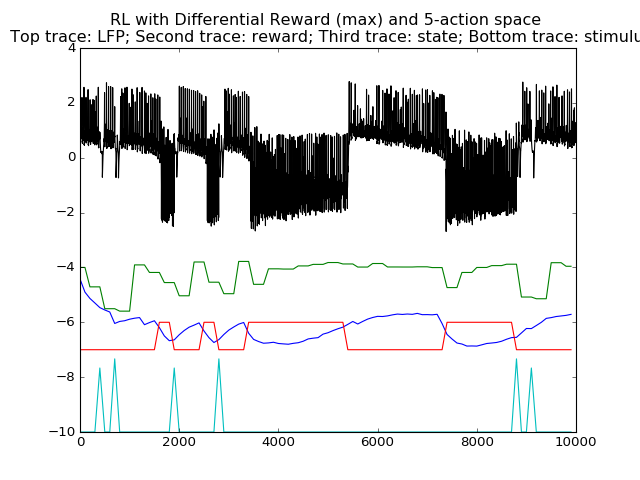

In [32]:
ttest -= ttest[0]
plot((ttest[:]),atest[:,0,9,0], 'k')
plot(dt*ttest[0:sim_time/dt], np.array(rewards) - 4.)
plot(dt*ttest[0:sim_time/dt], np.array(delta_rewards) - 4.)
plot(dt*ttest[0:sim_time/dt], np.array(states)[:,0] - 7.)
plot(dt*ttest[0:sim_time/dt], np.array(actions[0:sim_time/dt])/3. - 10)
title("RL with Differential Reward (max) and 5-action space \n Top trace: LFP; Second trace: reward; Third trace: state; Bottom trace: stimulus")

In [ ]:
bp_data = bp_filter_lfp(atest, 9, 100, 200, 1000, 10)
lo_data = lo_filter_lfp(atest, 9, 20, 1000, 10)
hi_data = hi_filter_lfp(atest, 9, 175, 1000, 10)

In [220]:
q_table

{((0,), 0): -0.099036928785102174,
 ((0,), 7): 0.057757305979939777,
 ((0,), 8): 0.20469881160508477}

#Previous Testing

In [95]:
take_action(0,stimulus)

(tt, aa), (x1, x2), (y1, y2) = s.run(simulation_length = 5000)  


<IPython.core.display.Javascript object>


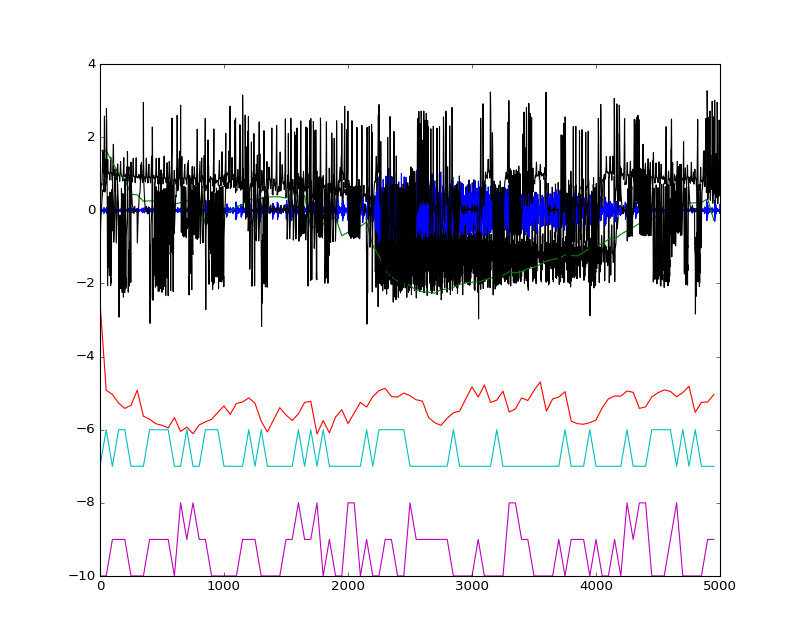

In [111]:
dt = 50
N_frames = len(tt)/dt
time_const = 5

lfpbars = []
rewards = []

for i in range (N_frames):

    if i == 0:
        reward_t, lfpbar_t = (get_reward(aa[dt*i:dt*(i+1)], 0,time_const))
    else:
        reward_t, lfpbar_t = (get_reward(aa[dt*i:dt*(i+1)], lfpbars[i-1],0,time_const))
        
    rewards.append(reward_t)
    lfpbars.append(lfpbar_t)


figure = figsize(10, 8)
bp_data = bp_filter_lfp(aa, 9, 100, 200, 1000, 10)
lo_data = lo_filter_lfp(aa, 9, 20, 1000, 10)
hi_data = hi_filter_lfp(aa, 9, 175, 1000, 10)

tt -= tt[0]
plot((tt[:]),aa[:,0,9,0], 'k')
plot(hi_data)
plot(dt*tt[0:N_frames], rewards)

#plot(bp_data)
#ylim(-3,3)

#plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(action_log)/6. - 3, 'k')
#(amp_plot, freq_plot) = get_freq_amp(action_plan)


#plot( 100*(tt[:(len(action_plan))]), np.array(states)[:,0]/2. - 5, 'b')
#plot( dt+100*(tt[:(len(action_plan))]), np.array(amp_plot)/6. - 4, 'b')


#plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(freq_plot)/200. - 3, 'g')
#title("2-state 2-action Q-learning Algorithm \n Simplified state (memoryless)")

#show()

In [315]:
get_reward(aa[100:150], 0.93908531746564694, 0)

(1.6920136109950235, 0.18414834727885215)

In [137]:
actions

[0,
 4,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 4,
 4,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 2,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 1,
 2,
 3,
 2,
 4,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 4,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]